In [ ]:
Librairies

In [5]:
import yfinance as yf
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt, exp, log
from scipy.stats import norm
from numpy import mean, std
from random import gauss
import matplotlib.pyplot as plt
import warnings

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)
warnings.simplefilter(action='ignore', category=FutureWarning)

B&S model for vailla option pricing

In [259]:
####### Model's parameters
S = 100
T = 250     # Time to maturity in days
t = T/250    # Time to maturity in years counting 250 trading days
r = 0.05
vol = 0.20
K = 100 * exp(-r*t)

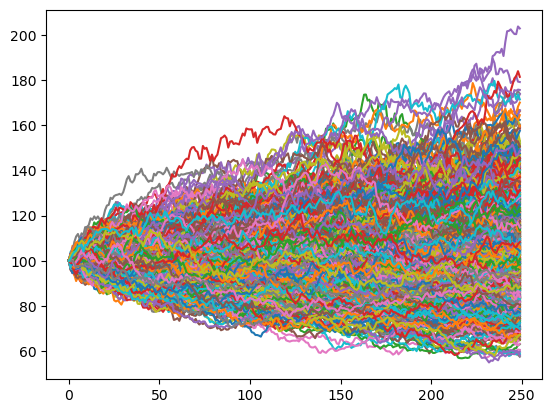

In [263]:
def Actif_diffusion(Stock_price, rate, Vol, dt) :
    #dSt = rSt*dt + Vol*dWt
    Increment =  Stock_price * ((rate * dt) + (Vol * sqrt(dt) * np.random.normal(0, 1, 1)[0]))
    return(Stock_price + Increment)

# ####### Unique difusion
# Stock = [S]
# for i in range(1,T):
#     dt = 1 / T
#     Stock.append(Actif_diffusion(Stock[i-1], r, vol, dt))

# pd.DataFrame(Stock).plot()
# plt.show()

####### Monte Carlo for price diffusion in the B&S model
Nombre_de_lancer = 1000
N_Stocks = [] 
for num_difu in range(0, Nombre_de_lancer) :
    Stock = [S]
    for i in range(1,T):
        dt = 1 / T
        Stock.append(Actif_diffusion(Stock[i-1], r, vol, dt))
    N_Stocks.append(Stock)

pd.DataFrame(N_Stocks).transpose().plot() 
plt.legend().remove()
plt.show()

Final_prices = pd.DataFrame(N_Stocks).transpose().loc[T - 1]

European options 

European options
##################################################
Price of the call :
using the Monte Carlo method :  13.146047822282673
For the B&S formula :  13.2696765846609
Difference beetween the 2 methods : 0.1236287623782264
##################################################
Price of the put :
using the Monte Carlo method :  3.98906393279698
For the B&S formula :  3.7534183882568506
Difference beetween the 2 methods : -0.23564554454012931
##################################################




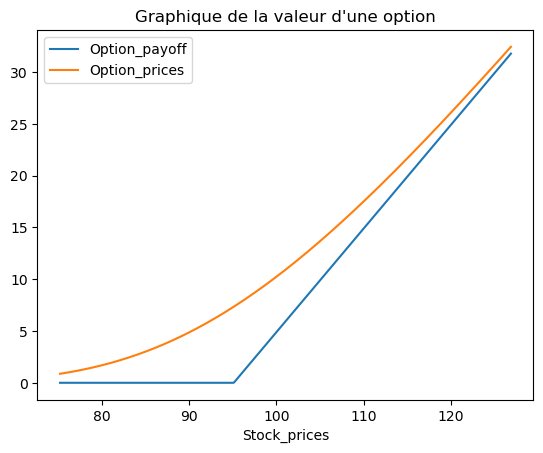

In [265]:
## In continuous time and trading for 250 days within a year
Call_Payoff = [max(x - K, 0) for x in Final_prices]
Put_Payoff = [max(K - x, 0) for x in Final_prices]

Call_Price_Monte_Carlo = mean(Call_Payoff) * exp(-r*t)
Put_Price_Monte_Carlo =  mean(Put_Payoff) * exp(-r*t)

##### B&S's closed formula
d1 = (log(S/K) + (r + (vol**2)/2) * t) / (vol * sqrt(t))
d2 = d1 - vol * sqrt(t)

Call_Price_static = S*norm.cdf(d1) - K*exp(-r*t)*norm.cdf(d2)
Put_Price_static = K*exp(-r*t)*norm.cdf(-d2) - S*norm.cdf(-d1)

print("European options")
print("#" * 50)
print("Price of the call :")
print("using the Monte Carlo method : ", Call_Price_Monte_Carlo)
print("For the B&S formula : ", Call_Price_static)
print("Difference beetween the 2 methods :", Call_Price_static - Call_Price_Monte_Carlo)
print("#" * 50)
print("Price of the put :")
print("using the Monte Carlo method : ", Put_Price_Monte_Carlo)
print("For the B&S formula : ", Put_Price_static)
print("Difference beetween the 2 methods :", Put_Price_static - Put_Price_Monte_Carlo)
print("#" * 50)
print("\n" )

## Graphs for the option value (intrinsic and payoff)
Options = {"Stock_prices" : [], "Option_payoff" : [], "Option_prices" : []}
Options["Stock_prices"] = [S + i/10.0 for i in range(-round(np.log(T) * 45), round(np.log(T)) * 45, 1)]
# We use this technic in order to make small incrementes of S, if not we get cases where the payoff function is not linear after K 
# One can try using : Options["Stock_prices"] = [i for i in range(S-20, S+20, 1)]
Options["Option_payoff"] = [max(i - K, 0) for i in Options["Stock_prices"]]

for Stock_price in Options["Stock_prices"] : 
    d1 = (log(Stock_price/K) + (r + (vol**2)/2) * t) / (vol * sqrt(t))
    d2 = d1 - vol * sqrt(t)
    Options["Option_prices"].append(Stock_price*norm.cdf(d1) - K*norm.cdf(d2))
    
pd.DataFrame(Options).set_index("Stock_prices").plot(title = "Graphique de la valeur d'une option") 
plt.show()

The Grecks - computed for a maturity of 150 days (the option's market rarely takes maturity up to a year, 3 to 6 months in general)

##################################################
Les grecques
Delta :  0.9954501306646902
Gamma :  0.0014301078376422554
Vega :  1.029677643102424
Theta :  -2.773745839464532
Rho :  57.53427207549549


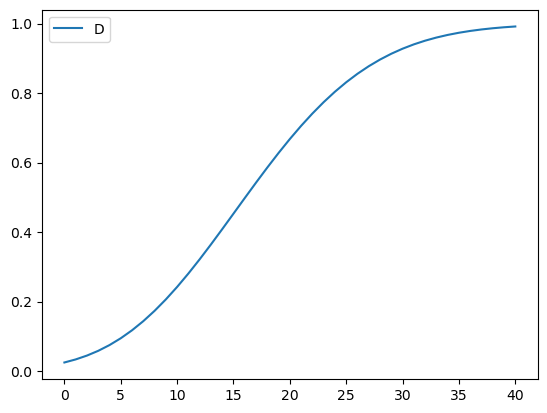

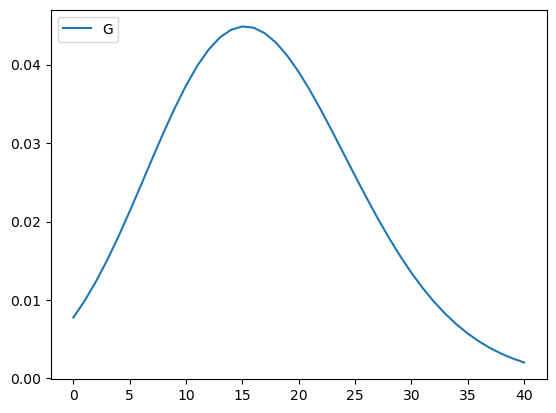

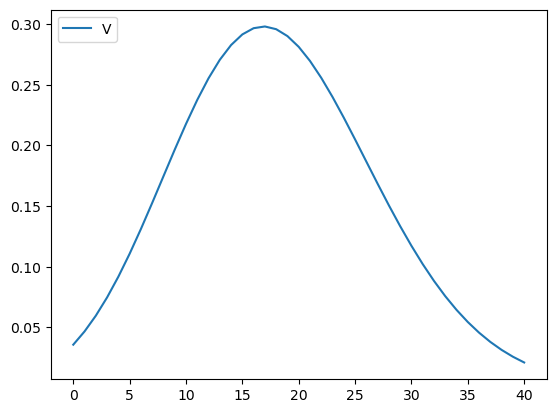

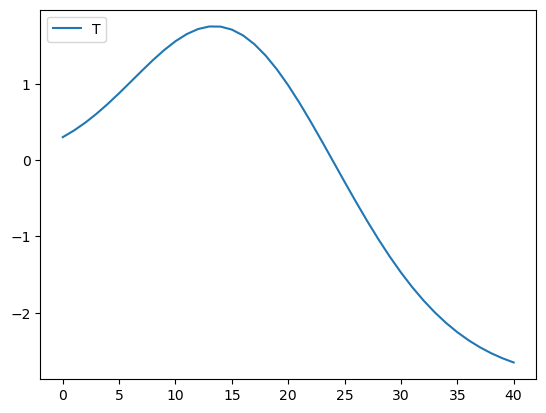

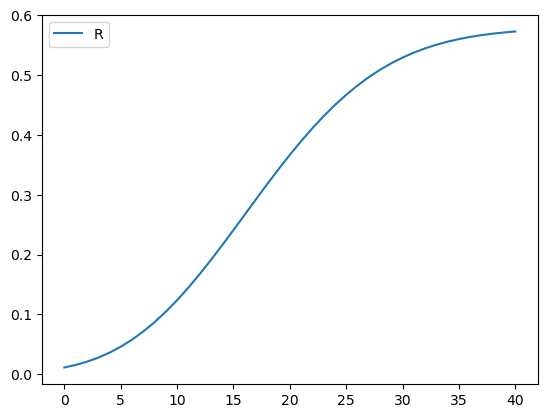

In [233]:
Delta = norm.cdf(d1)
Gamma = norm.pdf(d1) / (S * vol * sqrt(t))
Vega = S * norm.pdf(d1) * sqrt(t)
Theta = ((S * norm.pdf(d1) * vol) / (2*sqrt(t))) - r * K*exp(-r*t) * norm.cdf(d2)
Rho = t * K * exp(-r*t) * norm.cdf(d2)

print("#" * 50)
print("Les grecques")
print("Delta : ", Delta)
print("Gamma : ", Gamma)
print("Vega : ", Vega)
print("Theta : ", Theta)
print("Rho : ", Rho)
## Remarque : le vega et le rho sortent en % dans les formules de B&S

## Graphs for the grecks
Grecks = {"Deltas" : [], "Gammas" : [], "Vegas" : [], "Thetas" : [], "Rhos" : []}
S_grecks = [i for i in range(S-20, S+21, 1)]

for S_greck in S_grecks : 
    d1 = (log(S_greck/K) + (r + (vol**2)/2) * t) / (vol * sqrt(t))
    d2 = d1 - vol * sqrt(t)
    
    Grecks["Deltas"].append(norm.cdf(d1))
    Grecks["Gammas"].append(norm.pdf(d1) / (S_greck * vol * sqrt(t)))
    Grecks["Vegas"].append(S_greck * norm.pdf(d1) * sqrt(t)/100)
    Grecks["Thetas"].append(((S_greck * norm.pdf(d1) * vol) / (2*sqrt(t))) - r*K*exp(-r*t)*norm.cdf(d2))
    Grecks["Rhos"].append(t * K * exp(-r*t) * norm.cdf(d2)/100)
    

for greck in Grecks.keys() :
    pd.DataFrame(Grecks[greck]).plot() 
    plt.legend(greck, loc = "upper left")
    plt.show()

Asian options -- In progress

In [235]:
# It's Simplier using the vecteur but less easy to comprehende
Call_Payoff = [max(mean(x) - K, 0) for x in N_Stocks]
Put_Payoff = [max(K - mean(x), 0) for x in N_Stocks]

Asian_Call_Price_Monte_Carlo = mean(Call_Payoff) * exp(-r*t)
Asian_Put_Price_Monte_Carlo =  mean(Put_Payoff) * exp(-r*t)

print("Asian options")
print("#" * 30)
print("Price of the call :")
print("using the Monte Carlo method : ", Asian_Call_Price_Monte_Carlo)
print("Price of the put :")
print("using the Monte Carlo method : ", Asian_Put_Price_Monte_Carlo)

Asian options
##############################
Price of the call :
using the Monte Carlo method :  4.651900117619163
Price of the put :
using the Monte Carlo method :  1.47187833807024


In [ ]:
Asian floating options 

In [237]:
# It's Simplier using the vecteur but less easy to comprehende
Call_Payoff = [max(x[len(x)-1] - mean(x), 0) for x in N_Stocks]
Put_Payoff = [max(mean(x) - x[len(x)-1], 0) for x in N_Stocks]

Asian_Call_Price_Monte_Carlo = mean(Call_Payoff) * exp(-r*t)
Asian_Put_Price_Monte_Carlo =  mean(Put_Payoff) * exp(-r*t)

print("Asian floating options")
print("#" * 30)
print("Price of the call :")
print("using the Monte Carlo method : ", Asian_Call_Price_Monte_Carlo)
print("Price of the put :")
print("using the Monte Carlo method : ", Asian_Put_Price_Monte_Carlo)

Asian floating options
##############################
Price of the call :
using the Monte Carlo method :  3.7313780067988054
Price of the put :
using the Monte Carlo method :  2.0209936136141096
